In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.transforms import Bbox
import seaborn as sns
import scanpy as sc
import scipy
import sklearn

from importlib import reload

import plotting as plt2

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/hsc_landscape.anndata.h5ad"

adata = sc.read_h5ad(fpath)
sc.logging.print_memory_usage()

adata

Memory usage: current 8.75 GB, difference +8.75 GB


AnnData object with n_obs × n_vars = 54347 × 19070
    obs: 'n_counts', 'cell_type', 'dataset', 'organ_tissue', 'n_genes', 'new_cluster', 'cell_label', 'cluster_str', 'UMAP 1', 'UMAP 2'
    var: 'gene_name', 'ensemble_id', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'B_mem', 'B_naive', 'Baso', 'DC', 'Endo', 'Eos', 'Ery', 'Fibro', 'HSC', 'Macro', 'Mega', 'Mono', 'MDSC', 'Neut', 'Osteo', 'Plasma', 'pDC', 'Retic', 'Stromal', 'cluster_genes'
    uns: 'cell_type_colors', 'dataset_colors', 'go_annotations', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'organ_tissue_colors', 'panglaodb', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log_norm', 'raw_counts'
    obsp: 'connectivities', 'distances'

# Subset the data

In [3]:
# Filter for the relevant cell types: Hematopoietic stem cells (HSC) and induced HSC (iHSC)
cell_types = ['HSC', 'iHSC']
pdf = adata[adata.obs['cell_type'].isin(cell_types), :].copy()  # Explicit copy for safety

print("Number of cells after cell type filtering:", pdf.shape[0])

# # Further filter to include only datasets of interest: iHSC and young2_HSC
# datasets = ['iHSC', 'young2_HSC']
# pdf = pdf[pdf.obs['dataset'].isin(datasets), :]

print("Number of cells after dataset filtering:", pdf.shape[0])

# Clean up cell IDs to remove "_iHSC" suffix
pdf.obs['cell_id'] = pdf.obs.index.str.replace("_iHSC", "")

# Display distribution of cells across the filtered datasets
print("Dataset distribution:")
print(pdf.obs['dataset'].value_counts()) 

Number of cells after cell type filtering: 14372
Number of cells after dataset filtering: 14372
Dataset distribution:
dataset
iHSC              8574
young2_HSC        3243
pellin            1282
old2_BMMC_HSPC     945
old1_BMMC_HSPC     328
Name: count, dtype: int64


# Add QC Variables

In [4]:
fpath = "../resources/qc_barcodes.csv"
codes = pd.read_csv(fpath)
codes['OG_cluster'] = codes['cluster_str']

# Column to exclude from suffixing
exclude_column = 'cell_id'

# Suffix to add
suffix = '_QC'

# Create new column names with suffixes
new_columns = [col + suffix if col != exclude_column else col for col in codes.columns]

# Rename columns in the DataFrame
codes.columns = new_columns

print(f"{pdf.obs.shape=} {codes.shape=}")

pdf.obs = pd.merge(
    pdf.obs, 
    codes,
    how='left',
    left_on='cell_id',
    right_on='cell_id',
)

pdf.obs['OG_cluster_QC'] = pdf.obs['OG_cluster_QC'].fillna('HSC')

pdf.obs.head()

pdf.obs.shape=(14372, 11) codes.shape=(8563, 11)


,n_counts,cell_type,dataset,organ_tissue,n_genes,new_cluster,cell_label,cluster_str,UMAP 1,UMAP 2,...,predicted_doublet_QC,cluster_str_QC,candidate_QC,CD34_QC,GATA2_QC,GFI1B_QC,FOS_QC,STAT5A_QC,REL_QC,OG_cluster_QC
0,6558.0,iHSC,iHSC,nan,12480,1,Reprogrammed Cells,D2,8.989130,4.937538,...,False,C1,False,True,True,True,False,True,False,C1
1,5488.0,iHSC,iHSC,nan,12413,1,Reprogrammed Cells,D2,7.586400,4.889987,...,False,C1,False,False,False,False,False,False,False,C1
2,4330.0,iHSC,iHSC,nan,11906,10,Reprogrammed Cells,D11,8.027761,3.311177,...,False,C4,False,False,True,False,False,False,False,C4
3,3442.0,iHSC,iHSC,nan,11861,10,Reprogrammed Cells,D11,8.584245,2.674468,...,False,C2,False,True,False,True,False,False,False,C2
4,14427.0,iHSC,iHSC,nan,13436,1,Reprogrammed Cells,D2,9.509144,4.923519,...,False,C1,False,True,True,False,False,False,False,C1


# Filter out FB-like cells
cluster C1 and C3 of the iHSC data are not considered here

In [5]:
pdf = pdf[pdf.obs['OG_cluster_QC'].isin(['HSC', 'C2', 'C4', 'C5']), :]
pdf

View of AnnData object with n_obs × n_vars = 8610 × 19070
    obs: 'n_counts', 'cell_type', 'dataset', 'organ_tissue', 'n_genes', 'new_cluster', 'cell_label', 'cluster_str', 'UMAP 1', 'UMAP 2', 'cell_id', 'predicted_doublet_QC', 'cluster_str_QC', 'candidate_QC', 'CD34_QC', 'GATA2_QC', 'GFI1B_QC', 'FOS_QC', 'STAT5A_QC', 'REL_QC', 'OG_cluster_QC'
    var: 'gene_name', 'ensemble_id', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'B_mem', 'B_naive', 'Baso', 'DC', 'Endo', 'Eos', 'Ery', 'Fibro', 'HSC', 'Macro', 'Mega', 'Mono', 'MDSC', 'Neut', 'Osteo', 'Plasma', 'pDC', 'Retic', 'Stromal', 'cluster_genes'
    uns: 'cell_type_colors', 'dataset_colors', 'go_annotations', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'organ_tissue_colors', 'panglaodb', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log_norm', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [6]:
# Highly variable
sc.pp.highly_variable_genes(
    pdf,
    n_top_genes=100,
    batch_key='dataset',
)

pdf.var['highly_variable'].value_counts()

/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


highly_variable
False    18970
True       100
Name: count, dtype: int64

In [7]:
# Define a dictionary mapping cell types to their full descriptions
cell_types = {
    "HSC": "Hematopoietic stem cells",
}

# Create a copy of the 'panglaodb' annotation data from the AnnData object's uns attribute
pang = pdf.uns['panglaodb'].copy() 

print("Cell type mappings from panglaodb:")

# Iterate through cell types
for k, v in cell_types.items():
    # Find genes associated with the current cell type in the panglaodb
    genes = pang[pang['cell_type'] == v]['gene_name'].values  
    
    # Add a boolean column to the pdf.var DataFrame indicating whether each gene is in this cell type
    pdf.var[k] = pdf.var['gene_name'].isin(genes) 
    
    # Filter the genes that are expressed in this cell type
    exp_genes = pdf.var[pdf.var[k]]['gene_name']
    
    # Print the number of genes expressed in this cell type
    print(f"  - {v} ({k}): {len(exp_genes)} genes")  

print("Created boolean columns in pdf.var for each cell type.")

# Create a new 'cluster_genes' column in pdf.var that is True if the gene is in ANY of the cell type lists
pdf.var['cluster_genes'] = pdf.var[list(cell_types.keys())].any(axis=1)  

# Print a summary of how many genes are labeled as 'cluster_genes'
print("\nSummary of cluster genes:")
print(pdf.var['cluster_genes'].value_counts()) 

Cell type mappings from panglaodb:
  - Hematopoietic stem cells (HSC): 88 genes
Created boolean columns in pdf.var for each cell type.

Summary of cluster genes:
cluster_genes
False    18982
True        88
Name: count, dtype: int64


In [8]:
# Load the 'panglaodb' annotation data from the AnnData object.
pang = pdf.uns['panglaodb'].copy()  # Make a copy to avoid modifying the original data

# Get the gene names that are marker genes for the hematopoietic stem cell (HSC) cluster.
marker_genes = pang[pang['cell_type'] == 'Hematopoietic stem cells']['gene_name'].to_list()

# Get the gene names from the 'go_annotations' and 'highly_variable' gene sets.
GO_genes = pdf.uns['go_annotations']['gene_name'].to_list()
hvg = pdf.var[pdf.var['highly_variable']]['gene_name'].to_list()

print(f'Identified {len(marker_genes)} HSC marker genes, {len(GO_genes)} GO annotated genes, and {len(hvg)} highly variable genes.')

# Combine the lists of marker genes, GO genes, and highly variable genes.
all_genes_of_interest = marker_genes + GO_genes + hvg

# Add a boolean column to the AnnData object's gene metadata, indicating whether each gene is in the list of combined genes.
pdf.var['hsc_cluster_genes'] = pdf.var['gene_name'].isin(all_genes_of_interest)

# Display the distribution of genes (how many are in or not in the 'hsc_cluster_genes' group)
print("\nSummary of genes of interest for HSC cluster:")
print(pdf.var['hsc_cluster_genes'].value_counts()) 

Identified 88 HSC marker genes, 81 GO annotated genes, and 100 highly variable genes.

Summary of genes of interest for HSC cluster:
hsc_cluster_genes
False    18825
True       245
Name: count, dtype: int64


# PCA and clustering 

Performing PCA dimensionality reduction...


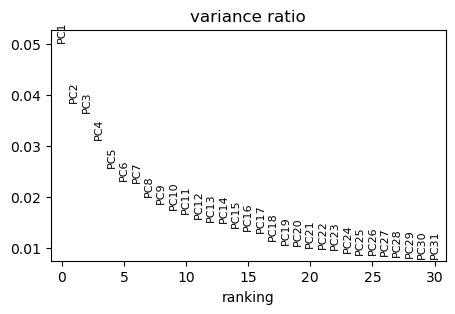

In [9]:
# PCA Analysis
print("Performing PCA dimensionality reduction...")
sc.pp.pca(
    pdf, 
    n_comps=50, 
    mask_var='hsc_cluster_genes',
)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 5, 3
sc.pl.pca_variance_ratio(
    pdf, 
)

Calculating nearest neighbors...
Computing UMAP embedding...
Running Leiden clustering algorithm...


/tmp/ipykernel_2675806/2286307185.py:18: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(



Cluster distribution:
hsc_cluster
0    1890
1    1672
2    1317
3    1254
4    1103
5     813
6     274
7     232
8      55
Name: count, dtype: int64


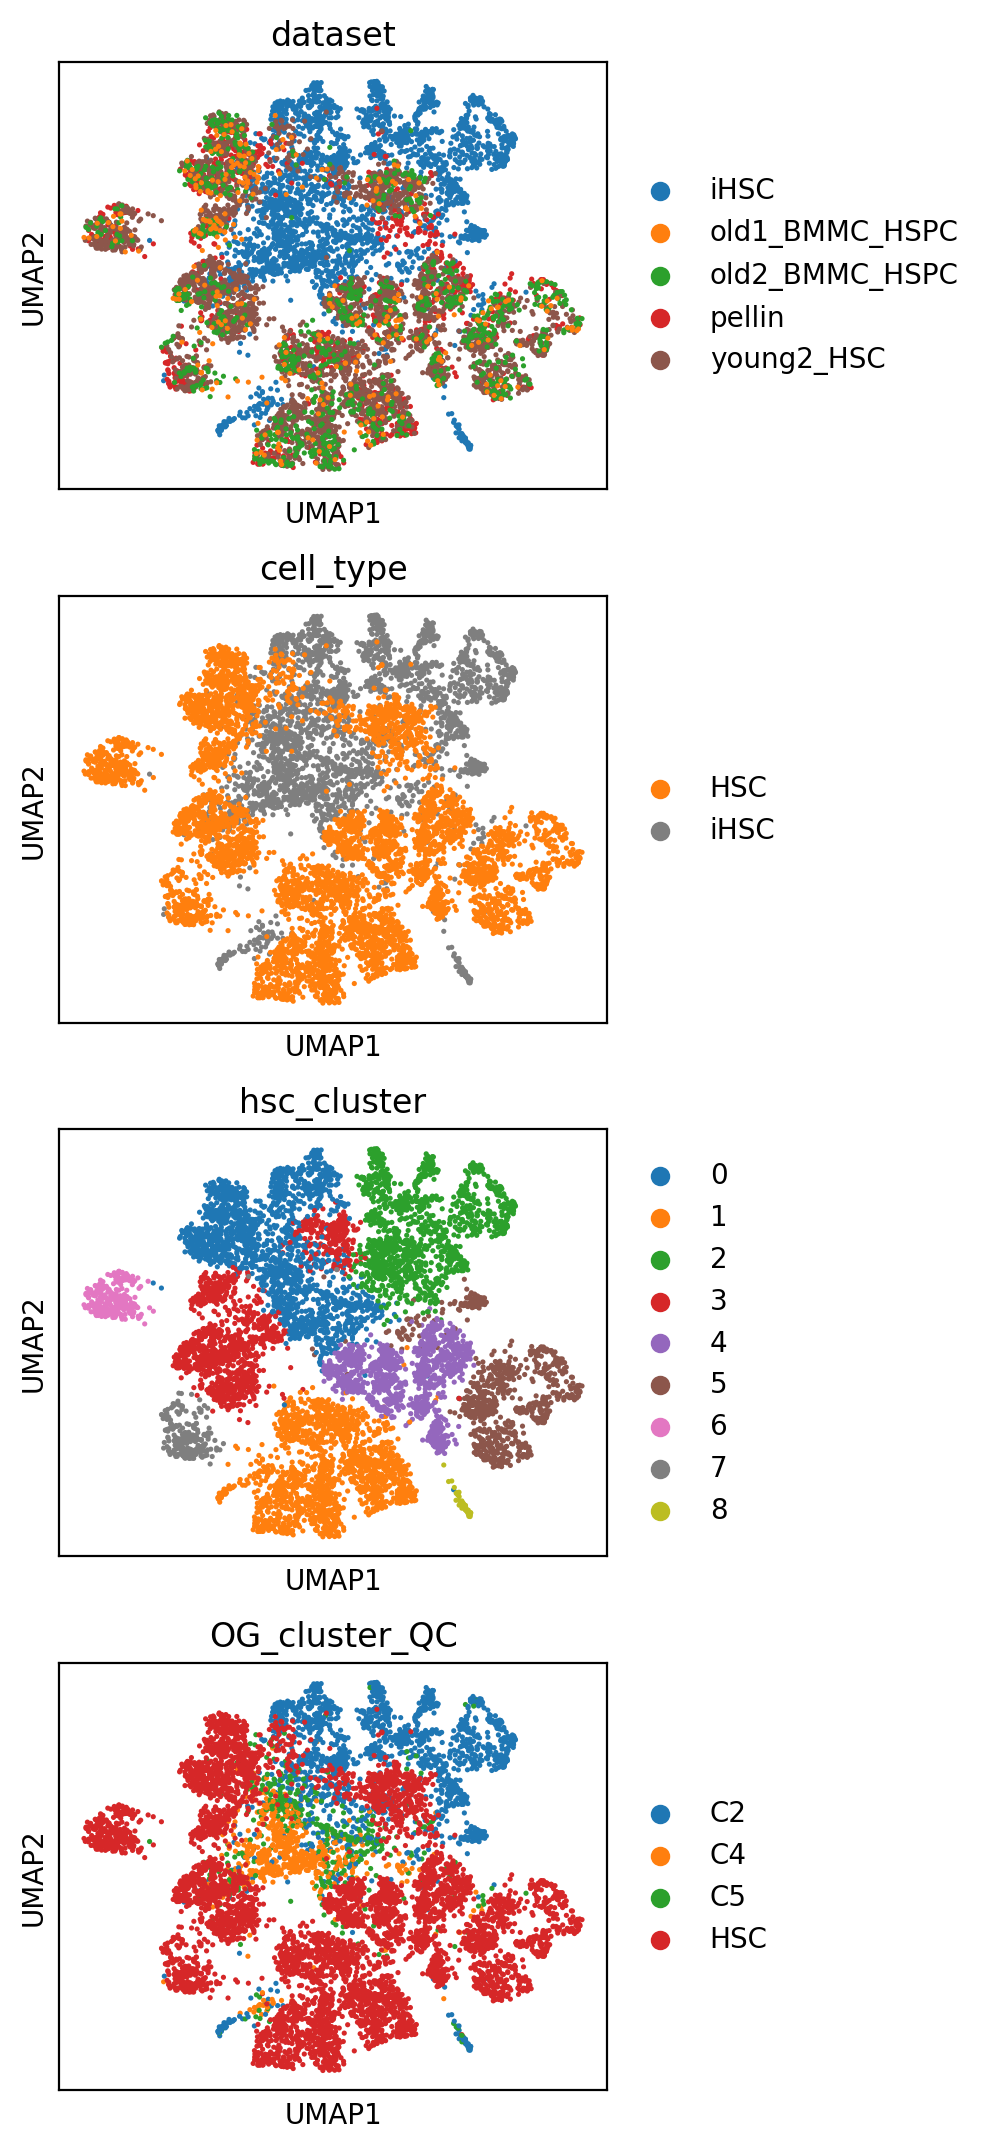

,n_counts,cell_type,dataset,organ_tissue,n_genes,new_cluster,cell_label,cluster_str,UMAP 1,UMAP 2,...,candidate_QC,CD34_QC,GATA2_QC,GFI1B_QC,FOS_QC,STAT5A_QC,REL_QC,OG_cluster_QC,hsc_cluster,hsc_cluster_str
2,4330.0,iHSC,iHSC,nan,11906,10,Reprogrammed Cells,D11,7.902703,6.233497,...,False,False,True,False,False,False,False,C4,0,H1
3,3442.0,iHSC,iHSC,nan,11861,10,Reprogrammed Cells,D11,8.317825,10.253451,...,False,True,False,True,False,False,False,C2,0,H1
8,3613.0,iHSC,iHSC,nan,11856,10,Reprogrammed Cells,D11,10.051177,4.810566,...,False,False,True,False,False,False,False,C5,0,H1
9,5500.0,iHSC,iHSC,nan,12225,10,Reprogrammed Cells,D11,12.190534,8.387062,...,True,False,False,False,False,False,False,C2,2,H3
11,3495.0,iHSC,iHSC,nan,11875,11,Reprogrammed Cells,D12,8.395482,9.907132,...,False,True,False,False,False,False,False,C2,0,H1


In [10]:
# Calculate Nearest Neighbors
print("Calculating nearest neighbors...")
sc.pp.neighbors(
    pdf,
    n_pcs=15, # approximate effective rank from above
    n_neighbors=35,
)

# UMAP Embedding
print("Computing UMAP embedding...")
sc.tl.umap(
    pdf,
    # min_dist=0.45
)

# Leiden Clustering
print("Running Leiden clustering algorithm...")
sc.tl.leiden(
    pdf, 
    resolution=0.25, 
    directed=True,
    key_added='hsc_cluster',
)

# Optionally, you can add a print statement to inspect the clusters:
print("\nCluster distribution:")
print(pdf.obs['hsc_cluster'].value_counts())

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3
# Plot it!
sc.pl.umap(
    pdf,
    color=['dataset','cell_type','hsc_cluster','OG_cluster_QC'],
    ncols=1,
)

pdf.obs['hsc_cluster_str'] = pdf.obs['hsc_cluster'].apply(lambda x: "H" + str(int(x) + 1))

pdf.obs['UMAP 1'] = pdf.obsm['X_umap'][:, 0]
pdf.obs['UMAP 2'] = pdf.obsm['X_umap'][:, 1]

pdf.obs.head()

In [11]:
# break

# Nice plots

,n_counts,cell_type,dataset,organ_tissue,n_genes,new_cluster,cell_label,cluster_str,UMAP 1,UMAP 2,...,candidate_QC,CD34_QC,GATA2_QC,GFI1B_QC,FOS_QC,STAT5A_QC,REL_QC,OG_cluster_QC,hsc_cluster,hsc_cluster_str
2,4330.0,iHSC,iHSC,nan,11906,10,Reprogrammed Cells,D11,7.902703,6.233497,...,False,False,True,False,False,False,False,C4,0,H1
3,3442.0,iHSC,iHSC,nan,11861,10,Reprogrammed Cells,D11,8.317825,10.253451,...,False,True,False,True,False,False,False,C2,0,H1
8,3613.0,iHSC,iHSC,nan,11856,10,Reprogrammed Cells,D11,10.051177,4.810566,...,False,False,True,False,False,False,False,C5,0,H1
9,5500.0,iHSC,iHSC,nan,12225,10,Reprogrammed Cells,D11,12.190534,8.387062,...,True,False,False,False,False,False,False,C2,2,H3
11,3495.0,iHSC,iHSC,nan,11875,11,Reprogrammed Cells,D12,8.395482,9.907132,...,False,True,False,False,False,False,False,C2,0,H1


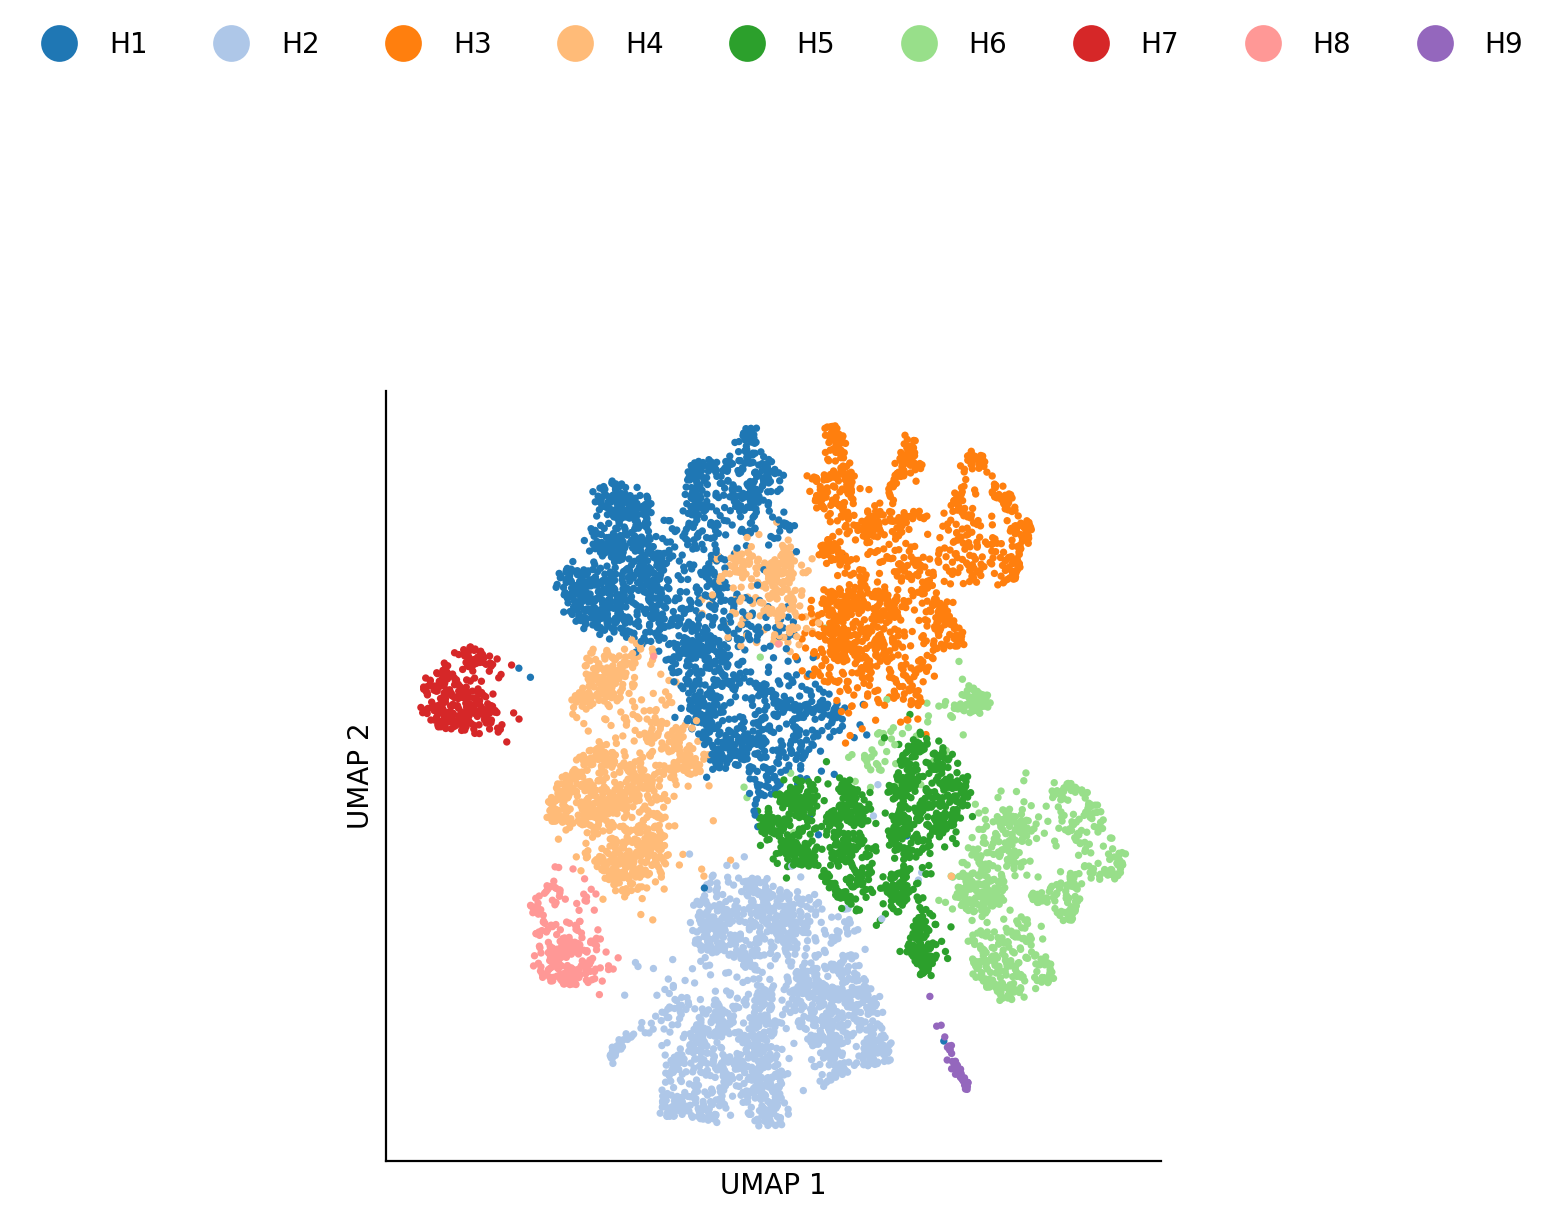

In [12]:
plot = pdf.obs.copy()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.scatterplot(
    data=plot,
    x='UMAP 1',
    y='UMAP 2',
    ec='none',
    s=7,
    hue='hsc_cluster_str',
    palette='tab20',
)

plt.xticks([])
plt.yticks([])

plt.ylabel('UMAP 2')
plt.xlabel('UMAP 1')
plt.gca().set_aspect('auto')
sns.despine()
# plt.axis(False)

sns.move_legend(plt.gca(),
                loc='upper right',
                title="",
                frameon=False,
                bbox_to_anchor=(1.5, 1.5),
                markerscale=5,
                ncol=9
               )
plot.head()

In [13]:
# plot = pdf.obs.copy()

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 5, 5

# sns.scatterplot(
#     data=plot,
#     x='UMAP 1',
#     y='UMAP 2',
#     s=7,
#     ec='k',
#     hue='cell_type',
#     palette=["k", "w"],
# )

# plt.xticks([])
# plt.yticks([])

# plt.ylabel('UMAP 2')
# plt.xlabel('UMAP 1')
# plt.gca().set_aspect('auto')
# sns.despine()
# # plt.axis(False)

# sns.move_legend(plt.gca(),
#                 loc='upper right',
#                 title="",
#                 frameon=False,
#                 bbox_to_anchor=(1.6, 1),
#                 markerscale=3,
#                 ncol=1,
#                )
# plot.head()

,n_counts,cell_type,dataset,organ_tissue,n_genes,new_cluster,cell_label,cluster_str,UMAP 1,UMAP 2,...,candidate_QC,CD34_QC,GATA2_QC,GFI1B_QC,FOS_QC,STAT5A_QC,REL_QC,OG_cluster_QC,hsc_cluster,hsc_cluster_str
2,4330.0,iHSC,iHSC,nan,11906,10,Reprogrammed Cells,D11,7.902703,6.233497,...,False,False,True,False,False,False,False,C4,0,H1
3,3442.0,iHSC,iHSC,nan,11861,10,Reprogrammed Cells,D11,8.317825,10.253451,...,False,True,False,True,False,False,False,C2,0,H1
8,3613.0,iHSC,iHSC,nan,11856,10,Reprogrammed Cells,D11,10.051177,4.810566,...,False,False,True,False,False,False,False,C5,0,H1
9,5500.0,iHSC,iHSC,nan,12225,10,Reprogrammed Cells,D11,12.190534,8.387062,...,True,False,False,False,False,False,False,C2,2,H3
11,3495.0,iHSC,iHSC,nan,11875,11,Reprogrammed Cells,D12,8.395482,9.907132,...,False,True,False,False,False,False,False,C2,0,H1


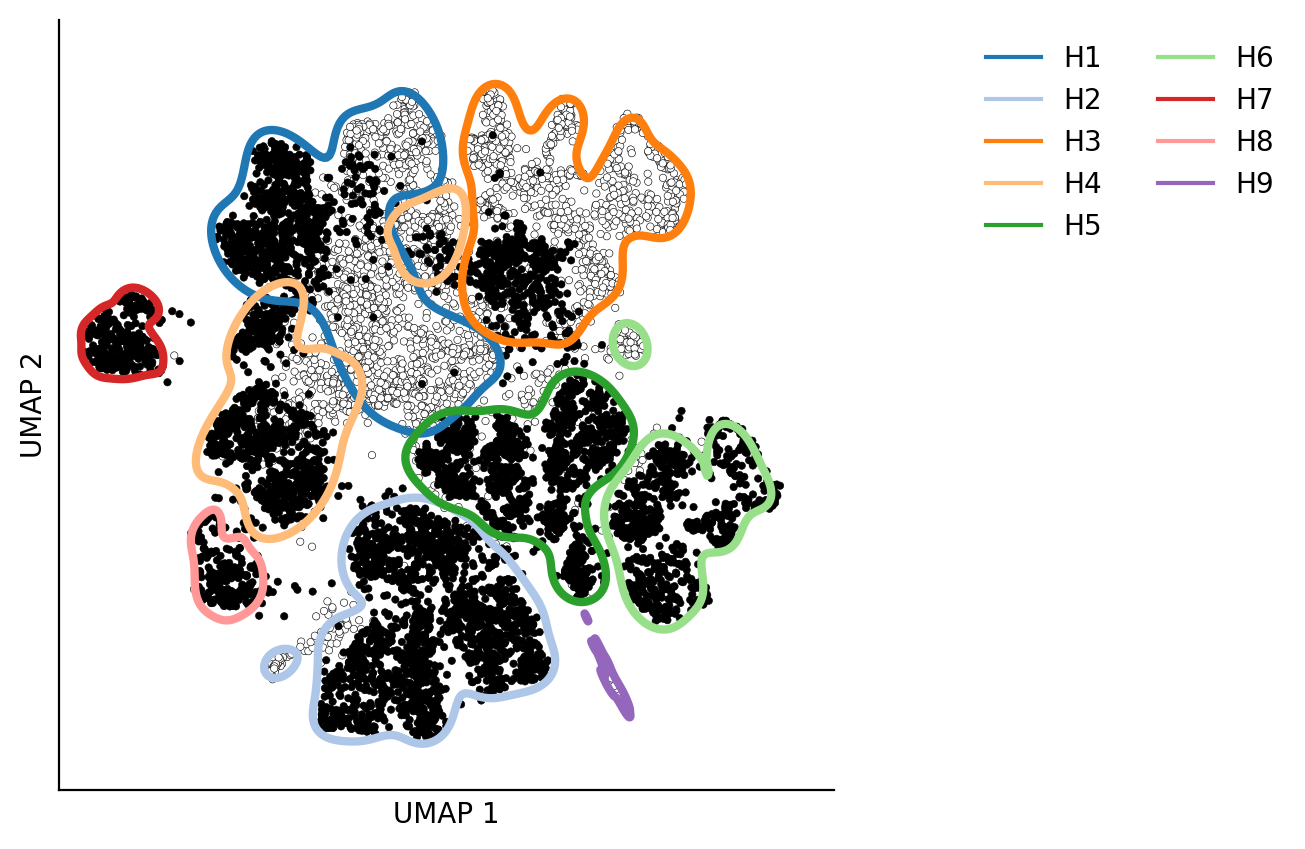

In [14]:
thresh = 0.15
plot = pdf.obs.copy()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.scatterplot(
    data=plot,
    x='UMAP 1',
    y='UMAP 2',
    s=7,
    ec='k',
    hue='cell_type',
    palette=["k", "w"],
)


sns.kdeplot(
    data=plot, 
    x='UMAP 1', 
    y='UMAP 2', 
    levels=2,  
    thresh=thresh,
    hue='hsc_cluster_str',
    palette='tab20',
    linewidths=3,
    zorder=2,
)

plt.xticks([])
plt.yticks([])

plt.ylabel('UMAP 2')
plt.xlabel('UMAP 1')
plt.gca().set_aspect('auto')
sns.despine()
# plt.axis(False)

sns.move_legend(plt.gca(),
                loc='upper right',
                title="",
                frameon=False,
                bbox_to_anchor=(1.6, 1),
                markerscale=5,
                ncol=2
               )
plot.head()

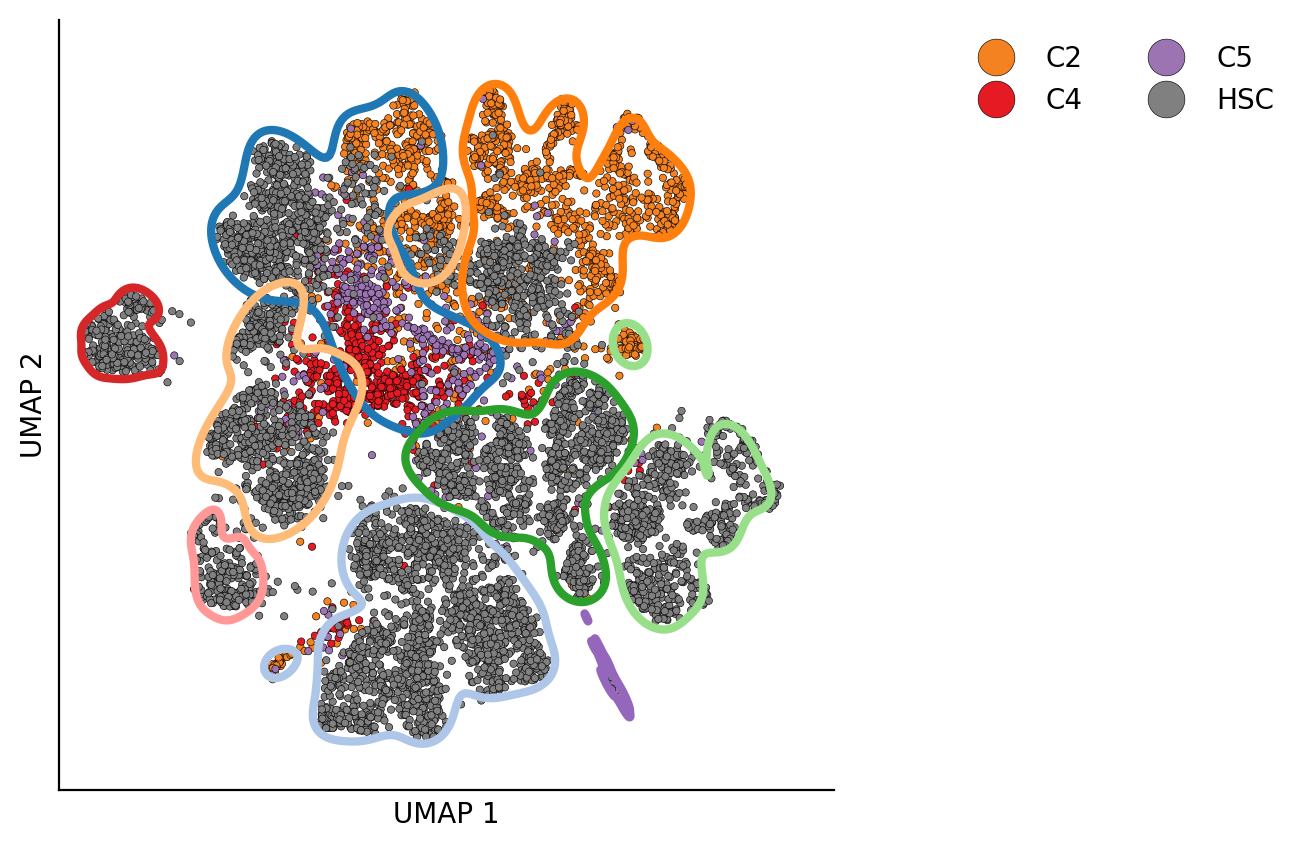

In [15]:
plot = pdf.obs.copy()
plot = plot.sort_values(by='OG_cluster_QC')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.scatterplot(
    data=plot,
    x='UMAP 1',
    y='UMAP 2',
    s=7,
    ec='none',
    color='lightgrey',
    zorder=0,
)


sns.kdeplot(
    data=plot, 
    x='UMAP 1', 
    y='UMAP 2', 
    levels=2,  
    thresh=thresh,
    hue='hsc_cluster_str',
    palette='tab20',
    linewidths=3,
    zorder=2,
)

sns.scatterplot(
    data=plot,
    x='UMAP 1',
    y='UMAP 2',
    s=7,
    ec='k',
    hue='OG_cluster_QC',
    palette=["#F58220", "#E51A23", "#9C74B2", 'Grey'],
)

sns.move_legend(plt.gca(),
                loc='upper right',
                title="",
                frameon=False,
                bbox_to_anchor=(1.6, 1),
                markerscale=5,
                ncol=2
               )

plt.xticks([])
plt.yticks([])

plt.ylabel('UMAP 2')
plt.xlabel('UMAP 1')
plt.gca().set_aspect('auto')
sns.despine()


In [16]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# Write the file out

In [ ]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/hsc_subclusters.anndata.h5ad"

pdf.obs['predicted_doublet_QC'] = pdf.obs['predicted_doublet_QC'].astype(float)
pdf.obs['cell_id'] = pdf.obs['cell_id'].astype(str)
pdf.obs['candidate_QC'] = pdf.obs['candidate_QC'].astype(str)
pdf.obs['OG_cluster_QC'] = pdf.obs['OG_cluster_QC'].astype(str)
pdf.obs['CD34_QC'] = pdf.obs['CD34_QC'].astype(str)
pdf.obs['GATA2_QC'] = pdf.obs['GATA2_QC'].astype(str)
pdf.obs['GFI1B_QC'] = pdf.obs['GFI1B_QC'].astype(str)
pdf.obs['FOS_QC'] = pdf.obs['FOS_QC'].astype(str)
pdf.obs['STAT5A_QC'] = pdf.obs['STAT5A_QC'].astype(str)
pdf.obs['REL_QC'] = pdf.obs['REL_QC'].astype(str)

# pdf.obs.dtypes

pdf.write_h5ad(fpath)
pdf

In [ ]:
break

In [ ]:
# plot = pdf.obs.copy()

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 5, 5

# sns.scatterplot(
#     data=plot,
#     x='UMAP 1',
#     y='UMAP 2',
#     s=7,
#     ec='k',
#     hue='candidate',
#     palette=["k", "r"],
# )


In [ ]:
break

In [ ]:
sc.pl.umap(
    pdf,
    color=["CD34", "HLF", "CRHBP", "MECOM", "HOPX", "AVP", "MLLT3"],
    s=100,
    ncols=3,
)

# Load QC Variables

In [ ]:
fpath = "../resources/qc_barcodes.csv"
codes = pd.read_csv(fpath)
codes['OG_cluster'] = codes['cluster_str']






codes.head()

In [ ]:
pdf.obs.head()

In [ ]:
break

# DEG

In [ ]:
sc.tl.rank_genes_groups(
    pdf, 
    groupby="hsc_cluster_str",
    method='wilcoxon',
    corr_method='benjamini-hochberg',
    pts=True,
    key_added='hsc_deg',
)

deg = sc.get.rank_genes_groups_df(
    pdf, 
    group=None,
    key='hsc_deg',
)

deg.head()

In [ ]:
sig = deg.copy()

alpha = 0.05
sig = sig[sig['pvals_adj'] <= alpha]
sig.head()